# Let's plot! 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import pandas as pd
import uproot as ur
import atlas_mpl_style as ampl
ampl.use_atlas_style()

In [3]:
# my worspace and directories

path_prefix = '/home/dportill/LCStudies/'
plotpath = path_prefix+'classifier/Plots/'
modelpath = path_prefix+'classifier/Models/'

In [4]:
# import our resolution utilities

import sys
sys.path.append(path_prefix)
from  util import resolution_util as ru
from  util import plot_util as pu
from  util import ml_util as mu

In [5]:
# Load data v7 with images from pubnote

inputpath = '/fast_scratch/atlas_images/v7/'
rootfiles = ["pi0", "piplus", "piminus"]

#setupPionData(inputpath, rootfiles, branches = []) on ml_util with defaultBranches from ClusterTree
trees, pdata = mu.setupPionData(inputpath, rootfiles)

In [6]:
# pdata -> Dictionary of dataframes. "pi0", "piplus", "piminus" are separated inside of the dictionary

np0 = len(pdata['pi0'])
npp = len(pdata['piplus'])
npm = len(pdata['piminus'])

print("Number of pi0 events: {}".format(np0))
print("Number of pi+ events: {}".format(npp))
print("Number of pi- events: {}".format(npm))
print("Total: {}".format(np0+npp+npm))

Number of pi0 events: 263891
Number of pi+ events: 435967
Number of pi- events: 434627
Total: 1134485


In [7]:
pcells = {
    ifile : {
        layer : mu.setupCells(itree, layer, flatten = False)
        for layer in mu.cell_meta
    }
    for ifile, itree in trees.items()
}

In [8]:
import numpy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow import keras as keras

In [9]:
import tensorflow as tf

In [10]:
## let's just take one gpu:
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [11]:
# create train/validation/test subsets containing 70%/10%/20%
# of events from each type of pion event
# merge pi0 and pi+ events
training_classes = ['pi0','piplus']
pdata_merged, pcells_merged, plabels = mu.createTrainingDatasets(training_classes, pdata, pcells)

In [12]:
pcellsE23_EMB2G_channels = mu.setupChannelImages(mu.rescaleImages(pcells_merged, (16, 16), layers=['EMB2', 'EMB3']),last=True)

In [13]:
pcellsE1_EMB1G_channels = mu.setupChannelImages(mu.rescaleImages(pcells_merged, (128, 4), layers=['EMB1']),last=True)

In [14]:
pcellsT123_T1G_channels = mu.setupChannelImages(mu.rescaleImages(pcells_merged, (4, 4), layers=['TileBar0', 'TileBar1', 'TileBar2']),last=True)

In [15]:
model_p1_d02=tf.keras.models.load_model(modelpath+'model_p1_d02_v2.h5')

In [16]:
scores_p1_d02 = model_p1_d02.predict([pcellsE1_EMB1G_channels, pcellsE23_EMB2G_channels, pcellsT123_T1G_channels])

ENERGY BINS

In [17]:
varlist = []
cluster_e = pu.rocVar(
    name='clusterE',
    bins=[1,10,50,500],
    df=pdata_merged,
    latex='Cluster E',
    vlist=varlist,
)

<Figure size 799.992x599.976 with 0 Axes>

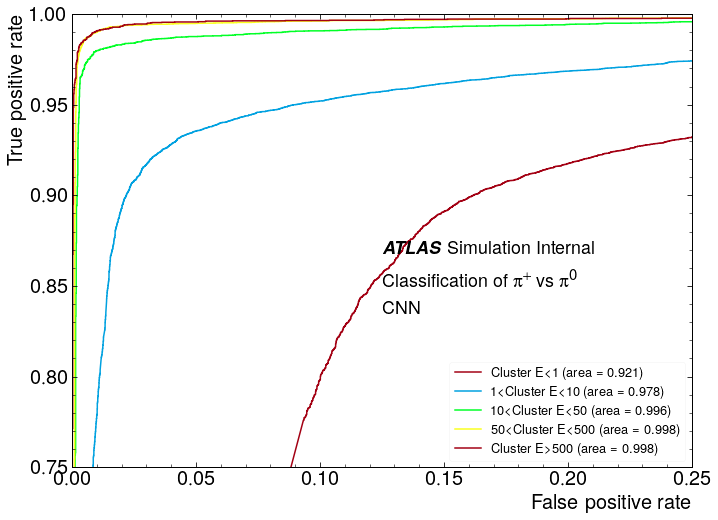

In [18]:
pu.rocScan(varlist, [scores_p1_d02[:,1]], ['CNN'], plabels, pdata_merged, 
            plotpath=  plotpath+ 'CNN_epochs100_v2_roc_zoom.pdf',
            x_min = 0.0, x_max = 0.25, y_min = 0.75, y_max = 1.0,
            atlas_x = 0.5, atlas_y = 0.5, simulation = True,
            textlist = [{'x': 0.5, 'y': 0.4, 'text': 'Classification of $\pi^{+}$ vs $\pi^{0}$'},
                        {'x': 0.5, 'y': 0.34, 'text': 'CNN '}])

In [19]:
#print(plabels) #-> 0 for pi0, 1 for piplus
print(pdata['piplus']['label']==1) # -> true-> 0 for pi0, 1 for piplus


#print(pdata['pi0'].keys()) # ['pi0', 'piplus', 'piminus'] -> Index(['clusterIndex', 'truthE', 'nCluster', 'clusterE', 'clusterECalib',
     #  'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells',
     #  'cluster_sumCellE', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T',
     #  'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY',
     #  'cluster_HAD_WEIGHT', 'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS',
     #  'cluster_cellE_norm', 'train', 'test', 'val', 'label'],
     # dtype='object')
#print(pdata_merged.keys()) # same keys as pdata
#print(pdata_merged['train']==1) #-> true  for the one that we will use for plotting

0         True
1         True
2         True
3         True
4         True
          ... 
435962    True
435963    True
435964    True
435965    True
435966    True
Name: label, Length: 435967, dtype: bool


In [20]:
#def roc_plot_scores(scores, ylabels, data, figfile='',
#             x_label='False positive rate',
#             y_label='True positive rate',
#             x_min=0, x_max=1.1, x_log=False,
#             y_min=0, y_max=1.1, y_log=False,
#             linestyles=[], colorgrouping=-1,
#             extra_lines=[], labels=[], rejection = False,
#             atlas_x=-1, atlas_y=-1, simulation=False, atlas_status = 'Internal',
#             textlist=[], title=''):

In [21]:
1-pdata_merged.cluster_EM_PROBABILITY.to_numpy()

array([0.29155678, 0.15355414, 0.1029858 , ..., 0.99869555, 0.17689842,
       0.9996782 ], dtype=float32)

In [22]:
#pu.roc_plot_scores([1-pdata_merged.cluster_EM_PROBABILITY.to_numpy(),scores_p1_d02[:,1]],plabels,pdata_merged,)

In [23]:
#pu.roc_plot_scores([ 1-scores_p1_d02[:,1], pdata_merged.cluster_EM_PROBABILITY.to_numpy()], plabels, pdata_merged, 
#            figfile = plotpath+'model_compare.pdf',
#            labels = ['CNN', 'LC EMProb'],
#            x_min = 0.925, x_max = 1.0, y_min = 1, y_max = 1000, 
#            x_log = False, y_log = True, rejection = True, 
#            x_label = '$\pi^{+}$ Efficiency', y_label = '$\pi^{0}$ Rejection',
#            atlas_x = 0.05, atlas_y = 0.925, simulation = True,
#            linestyles = ['-','--','-.',':'], colorgrouping = -1,
#            textlist = [{'x': 0.05, 'y': 0.8, 'text': 'Classification of $\pi^{+}$ vs $\pi^{0}$'}])